In [1]:
#!pip install tensorflow==2.5.0 

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 1000
embedding_dim = 16
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 88.0MB/s]


In [4]:
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 15
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/15
625/625 - 8s - loss: 0.5776 - accuracy: 0.6862 - val_loss: 0.4429 - val_accuracy: 0.7945 - 8s/epoch - 13ms/step
Epoch 2/15
625/625 - 3s - loss: 0.3965 - accuracy: 0.8198 - val_loss: 0.4034 - val_accuracy: 0.8138 - 3s/epoch - 5ms/step
Epoch 3/15
625/625 - 2s - loss: 0.3692 - accuracy: 0.8331 - val_loss: 0.3996 - val_accuracy: 0.8132 - 2s/epoch - 4ms/step
Epoch 4/15
625/625 - 3s - loss: 0.3600 - accuracy: 0.8367 - val_loss: 0.4028 - val_accuracy: 0.8156 - 3s/epoch - 4ms/step
Epoch 5/15
625/625 - 3s - loss: 0.3560 - accuracy: 0.8382 - val_loss: 0.4028 - val_accuracy: 0.8131 - 3s/epoch - 4ms/step
Epoch 6/15
625/625 - 3s - loss: 0.3543 - accuracy: 0.8377 - val_loss: 0.4052 - val_accuracy: 0.8116 - 3s/epoch - 4ms/step
Epoch 7/15
625/625 - 2s - loss: 0.3517 - accuracy: 0.8402 - val_loss: 0.4051 - val_accuracy: 0.8116 - 2s/epoch - 4ms/step
Epoch 8/15
625/625 - 3s - loss: 0.3520 - accuracy: 0.8388 - val_loss: 0.4063 - val_accuracy: 0.8141 - 3s/epoch - 4ms/step
Epoch 9/15
625/625 - 3s

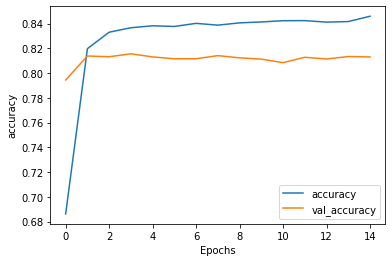

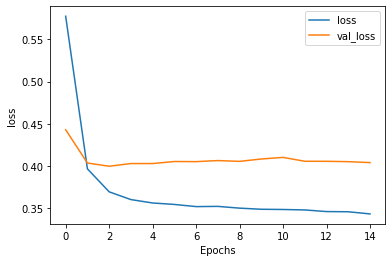

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting to fear <OOV> <OOV> series <OOV> thing she will have to <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(1000, 16)


In [14]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.32234368]
 [0.62524164]]
